#  What Drives Error? Clustering with Zillow

Presented by:  Sarah Lawson Woods 28 September 2021

Maggie (she/her)  2:07 PM
@channel: As you are working on projects, please remember what an executive summary should accomplish: it should be able to live on its one and be delivered to an executive to consume and understand in a quick couple of minutes, it should include the project goal, the key findings, and the recommendations. If you are unsure Agenda items do not belong on executive summary, algorithms used generally do not belong on executive summary (too technical for audience), performance metrics generally do not belong on executive summary unless the goal of the project is  a production ready model when you then communicate in human terms, we can expect this predictive model to perform at x% accuracy/be off by an average of x units. But generally what you are delivering are insights.

## Executive Summary

Goals: The purpose of this project is create a regression model with using Kmeans clusters (if proven valuable) to predicts the drivers of logerror of Zillow homes in three counties of California (Los Angeles County, Orange County, and Ventrua County).

Target: logerror which is the difference in the predicted zestimate and the actual home sale price

Findings: I created clusters with a focus on lot_size and area of the home, according to my first cluster the r-value is .0015
and the p-value is very high therefore we must fail to reject the HO and accept that there is not significant correlations
between lot_area and logerror. Next I performed a pearson r test on logerror and area to check for linear correlation and check the strength of the correlation alpha set to .05 and my results were that there is no strong linear correlation between area and logerror.

Results: Best predictors discovered were bedroom count, number of bedrooms, number of bathrooms, and square footage
Best-peforming model outperformed baseline and increased $R^2$ value by 0.2%

Conclusion and Next Steps: Some initial exploration and statistical testing revealed that some features that had better correlation with logerror were bedroom and bathroom and with more time, I would like to test these features in clustering.

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import os
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Exploring
import scipy.stats as stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures

# Modeling
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor


# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import math 
import wrangle_functions
import env
import acquire
import prepare

## Acquire

In [2]:
# using a SQL query I pull in the zillow data set for 2017 properties and predictions data for single 
# unit / single family homes from the Codeup database.
df = acquire.new_zillow_data()

In [3]:
# taking a look at the dataset
df.head()

,typeconstructiontypeid,storytypeid,propertylandusetypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,id,parcelid,basementsqft,...,id,parcelid,logerror,transactiondate,id,last_trans_date,propertylandusedesc,storydesc,typeconstructiondesc,parcelid
0,NaN,NaN,269.00,NaN,NaN,NaN,NaN,0,10754147,NaN,...,0,14297519,0.03,2017-01-01,0,2017-01-01,Planned Unit Development,None,None,10754147
1,NaN,NaN,261.00,NaN,NaN,NaN,NaN,1,10759547,NaN,...,1,17052889,0.06,2017-01-01,1,2017-01-01,Single Family Residential,None,None,10759547
2,NaN,NaN,47.00,NaN,5.00,NaN,NaN,2,10843547,NaN,...,2,14186244,0.01,2017-01-01,2,2017-01-01,Store/Office (Mixed Use),None,None,10843547
3,NaN,NaN,47.00,NaN,3.00,NaN,NaN,3,10859147,NaN,...,3,12177905,-0.10,2017-01-01,3,2017-01-01,Store/Office (Mixed Use),None,None,10859147
4,NaN,NaN,31.00,NaN,4.00,NaN,NaN,4,10879947,NaN,...,4,10887214,0.01,2017-01-01,4,2017-01-01,Commercial/Office/Residential Mixed Used,None,None,10879947


In [4]:
# Intially I will pull in 77,614 rows and 73 columns
df.shape

(77614, 73)

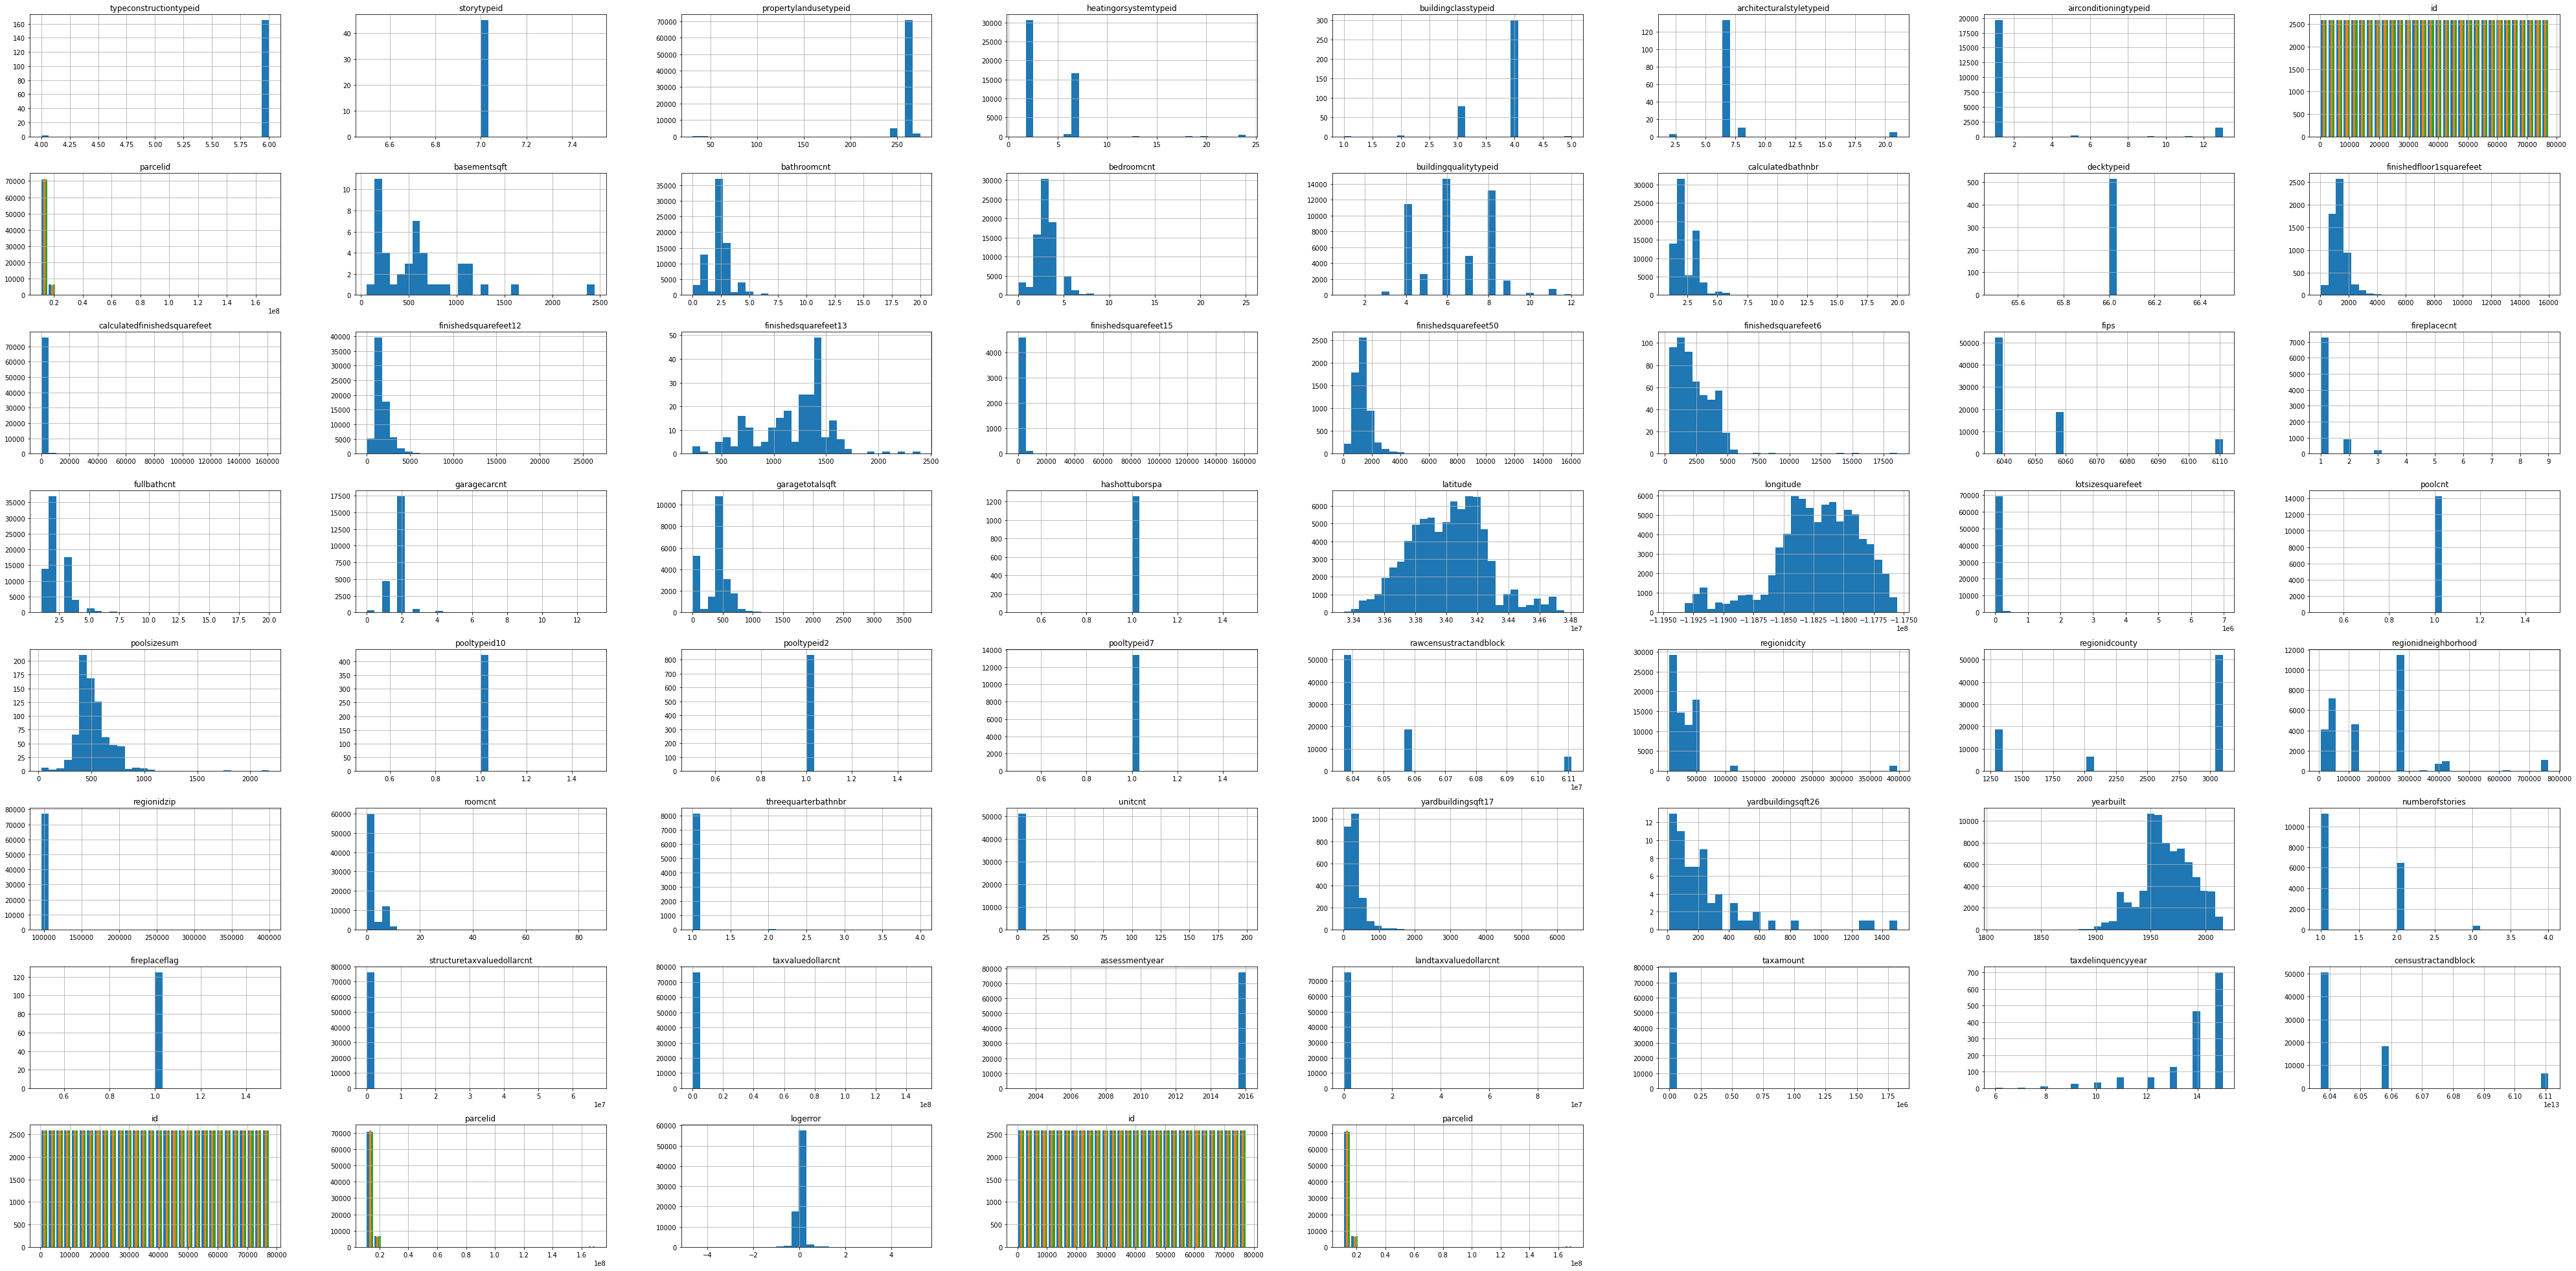

In [5]:
# plot histograms for all variables
df.hist(figsize=(70, 35), bins=30)
plt.show()

### Acquire Takeaways
- tax_value, landtaxvaluedollarcnt, bathrooms, bedrooms, area and logerror are normally distributed
- taxamount, structuretaxvaluedollarcnt is right skewed
- initially pulled in 77614 rows and  73 columns

## Prepare

In [6]:
# here I have applied all of my preparation techniques from the prepare.py file using the prep_all_function
df, df_outs = prepare.prep_all_function(df)

With my prep_all_function started by summarizing the dataset, next I chose the necessary columns from the original 73 that best represented the information I thought might be useful to explore, cluster with and model on.  I imputed columns as I saw fit and dropped columns with more than 25% of missing values.  I removed outliers using a function that took the most extreme outliers from the main dataframe, but kept most other outliers and saved this df to use in modeling.  Also created a separate df that is scaled to use in modeling.

In [7]:
# after prepartion is performed my dataset now consists of 53,348 rows and 14 columns
df.shape

(57795, 14)

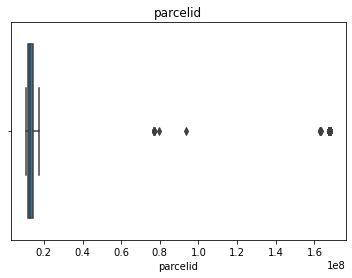

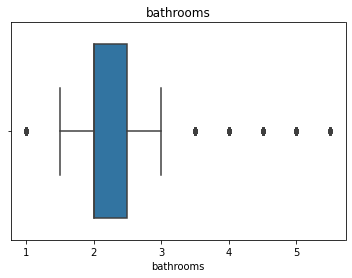

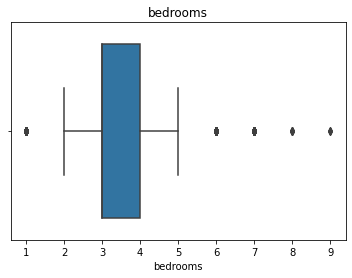

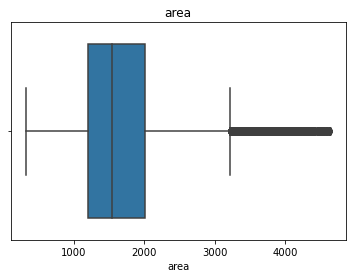

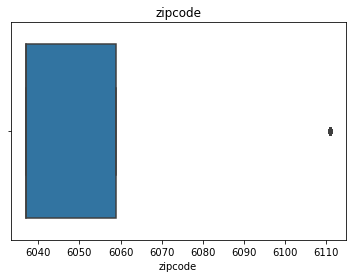

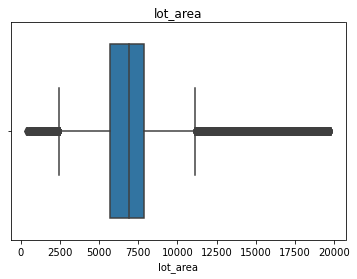

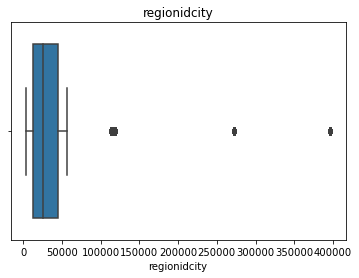

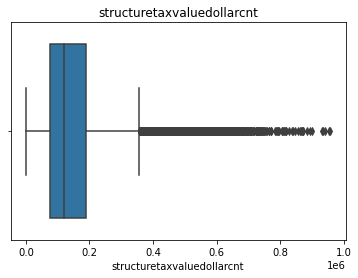

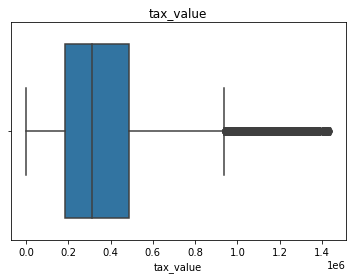

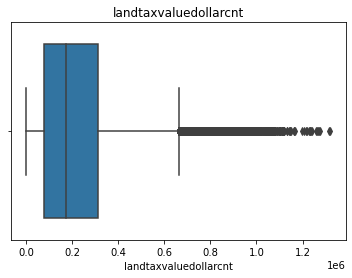

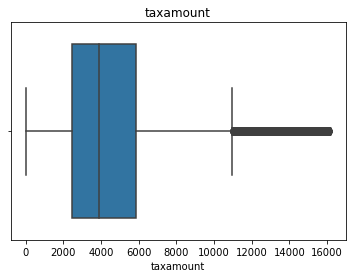

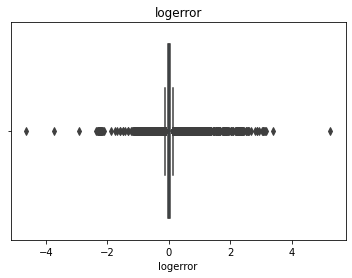

TypeError: Horizontal orientation requires numeric `x` variable.

In [8]:
# here are boxplots for all columns with some outliers removed
for col in df.columns:
    sns.boxplot(df[col])
    plt.title(col)
    plt.show()

In [13]:
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = prepare.train_validate_test(df, "logerror")

In [14]:
# now I will create a df that is scaled
_, train_scaled, validate_scaled, test_scaled = wrangle_functions.min_max_scaler(train, validate, test)

### Prepare Takeaways 
- I ended up after all prepartion was acccomplished with 57795 rows and 14 columns before I split the dataframe into train, test, split.
- I also created a scaled dataframe to use for modeling
- I created a feature called large_home that classified the any area over 2,300 to be in this category

## Explore

During this stage of the pipeline i I explored the interaction between independent variables such as area and 
lot_area through visualizations and statistical testing. Next I created clusters with these same variables since my visualizations indicated they had some correlation.

The topics of interest I would like to explore are:

    1. Is there a relationship between home lot_area and logerror?
    2. Is there a difference in logerror between small and large houses?(Viz size against logerror -Stats test      to confirm)
    
   

Text(0.5, 1.0, 'Features Correlating with Logerror')

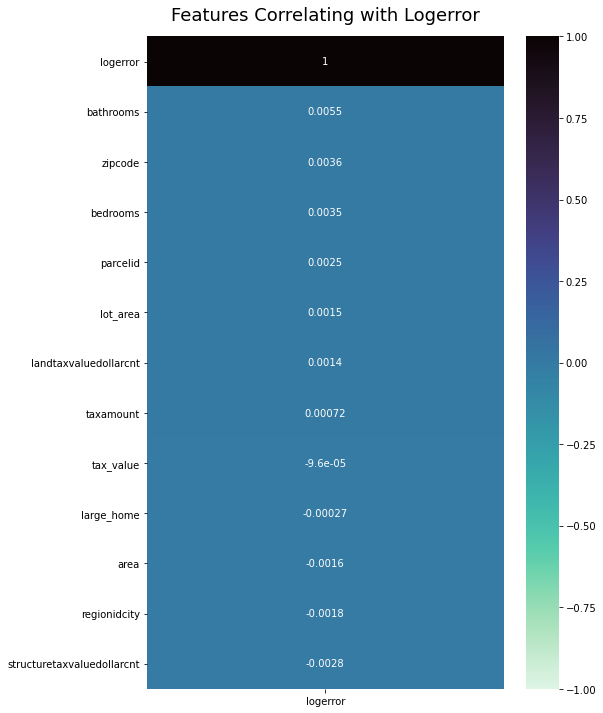

In [15]:
#see what correlates most with logerror with heatmap
plt.figure(figsize=(8, 12))
heatmap = sns.heatmap(df.corr()[['logerror']].sort_values(by='logerror', ascending=False), vmin=-1, vmax=1, annot=True, cmap='mako_r')
heatmap.set_title('Features Correlating with Logerror', fontdict={'fontsize':18}, pad=16)

In [16]:
# # choosing my features of focus based on my intial ideas
# X = train[['area', 'lot_area']]

In [17]:
# using the same features but scaling them
X_scaled = train_scaled[['area', 'lot_area']]

In [18]:
# also want to explore bedrooms and bathrooms since they have a stronger correlation than my initial features

### Start Clustering

### Cluster 1

In [19]:
# sklearn implementation of KMeans

#define it
kmeans_scaled = KMeans(n_clusters=3, random_state=777)

# fit it
kmeans_scaled.fit(X_scaled)

# Use/predict it
kmeans_scaled.predict(X_scaled)

array([0, 0, 0, ..., 1, 1, 0], dtype=int32)

In [21]:
# make a new column names cluster in df and X_scaled dataframe and X dataframe
cluster_features = ['area', 'lot_area']

X_scaled['cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

X_scaled['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

In [22]:
# taking a peek at the unscaled data
X.head()

NameError: name 'X' is not defined

In [23]:
X_scaled.head()

,area,lot_area,cluster,scaled_cluster
9402,0.22,0.39,0,0
10276,0.37,0.22,0,0
71332,0.35,0.26,0,0
26360,0.15,0.56,0,0
34540,0.21,0.31,0,0


In [24]:
# here I am creating the centroids for the clusters on scaled data
centroids = X_scaled.groupby('scaled_cluster')['area', 'lot_area'].mean()

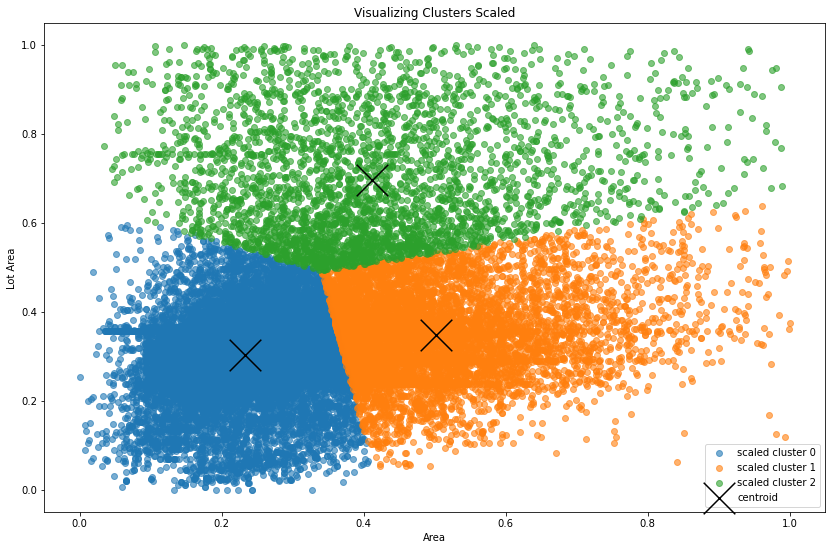

In [25]:
# now I am going to plot the unscaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('scaled_cluster'):
    plt.scatter(subset.area, subset.lot_area, label='scaled cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='lot_area', x='area', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Area')
plt.ylabel('Lot Area')
plt.title('Visualizing Clusters Scaled')
plt.show()

In [26]:
df['cluster'] = X_scaled['scaled_cluster']

<AxesSubplot:xlabel='cluster'>

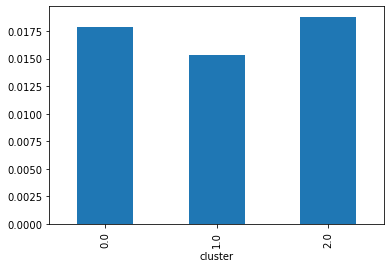

In [27]:
df.groupby('cluster').logerror.mean().plot.bar()

In [29]:
# check significance of cluster 1
#t-test comparing the mean log error for cluster 1
df[df.cluster==1].logerror.mean()

0.015311749703694486

H0: there is no difference between cluster 1  and the other two clusters.
H1: there is a difference between cluster 1  and the other two clusters.

In [31]:
# use a one sample two tailed t-test to compare means across clusters
a =.05

In [32]:
# t-test
t, p = stats.ttest_ind(df.logerror, df[df.cluster == 1].logerror)
t, p/2

(0.8403206921256919, 0.20036583699933613)

In [ ]:
# fail to reject HO because the p-value is high and indicates no significant relationship

### Cluster 2

In [33]:
X_scaled = train_scaled[['bedrooms', 'bathrooms']]

In [36]:
# make a new column names cluster in df and X_scaled dataframe and X dataframe
cluster_features = ['bedrooms', 'bathrooms']

X_scaled['cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

X_scaled['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

In [38]:
# here I am creating the centroids for the clusters on scaled data
centroids = X_scaled.groupby('scaled_cluster')['bedrooms', 'bathrooms'].mean()

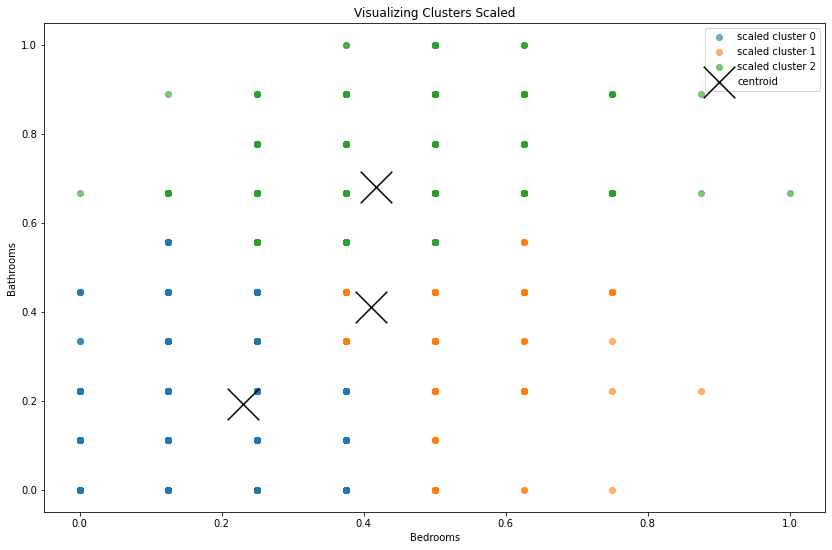

In [40]:
# now I am going to plot the scaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('scaled_cluster'):
    plt.scatter(subset.bedrooms, subset.bathrooms, label='scaled cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='bathrooms', x='bedrooms', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Bedrooms')
plt.ylabel('Bathrooms')
plt.title('Visualizing Clusters Scaled')
plt.show()

In [48]:
df['cluster'] = X_scaled['scaled_cluster']

<AxesSubplot:xlabel='cluster'>

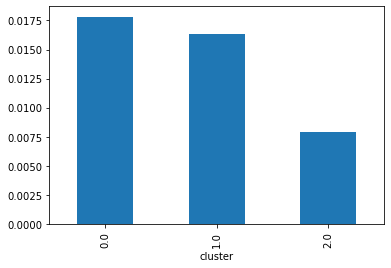

In [49]:
df.groupby('cluster').logerror.mean().plot.bar()

In [50]:
# check significance of cluster 2
#t-test comparing the mean log error for cluster 2
df[df.cluster==2].logerror.mean()

0.007943332969074316

H0: there is no difference between cluster 2  and the other two clusters.
H1: there is a difference between cluster 2  and the other two clusters.

In [52]:
# use a one sample two tailed t-test to compare means across clusters
a =.05

In [53]:
# t-test
t, p = stats.ttest_ind(df.logerror, df[df.cluster == 2].logerror)
t, p/2

(1.0641655216940575, 0.1436290690001871)

In [54]:
# fail to reject HO because the p-value is high and indicates no significant relationship

### Cluster 3

In [43]:
X_scaled = train_scaled[['taxamount', 'bedrooms']]

In [44]:
# make a new column names cluster in df and X_scaled dataframe and X dataframe
cluster_features = ['taxamount', 'bedrooms']

X_scaled['cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

X_scaled['scaled_cluster'] = kmeans_scaled.predict(X_scaled[cluster_features])

In [46]:
# here I am creating the centroids for the clusters on scaled data
centroids = X_scaled.groupby('scaled_cluster')['taxamount', 'bedrooms'].mean()

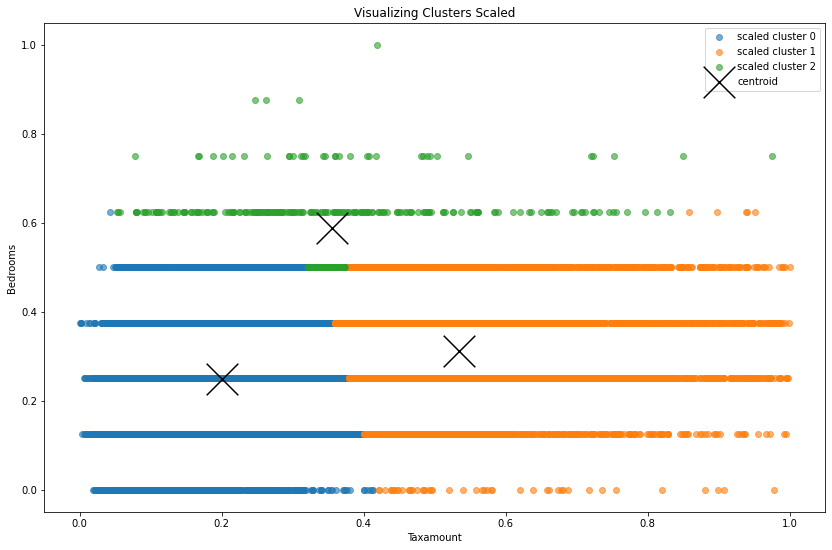

In [47]:
# now I am going to plot the scaled features
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('scaled_cluster'):
    plt.scatter(subset.taxamount, subset.bedrooms, label='scaled cluster ' + str(cluster), alpha=.6, cmap='reds')
centroids.plot.scatter(y='bedrooms', x='taxamount', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('Taxamount')
plt.ylabel('Bedrooms')
plt.title('Visualizing Clusters Scaled')
plt.show()

In [55]:
df['cluster'] = X_scaled['scaled_cluster']

<AxesSubplot:xlabel='cluster'>

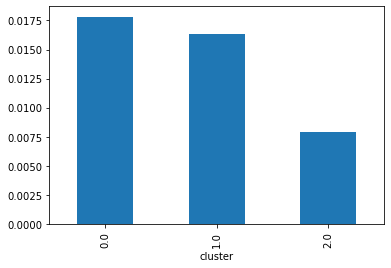

In [56]:
df.groupby('cluster').logerror.mean().plot.bar()

In [57]:
# check significance of cluster 2
#t-test comparing the mean log error for cluster 2
df[df.cluster==2].logerror.mean()

0.007943332969074316

H0: there is no difference between cluster 2  and the other two clusters.
H1: there is a difference between cluster 2  and the other two clusters.

### Explore Takeaways
- each variable has very little correlation to logerror based on the heatmap
- the variables with the best correlation are zipcode, bathrooms, landtaxvaluedollarcnt, and bedrooms
- my first cluster is on lot_size and area
-in order to see how well the clusters sorted the data
- I did a one sample two-tailed t-test to determine if the cluster 1 was different than the other 2.



In [ ]:
Conclusions and Next Steps
Results:
Best predictors discovered were bedroom count, number of bedrooms, number of bathrooms, and square footage
Best-peforming model outperformed baseline and increased $R^2$ value by 0.2%
Next Steps:
Try more feature combinations for clustering
More than 3 features
Try more feature combinations in models